Starting compression...
File 'sample1.txt' compressed to 'sample1_compressed.bin'
Original Size: 5762 bytes, Compressed Size: 3344 bytes
Compression Ratio: 41.96%
File 'sample2.pdf' compressed to 'sample2_compressed.bin'
Original Size: 42272 bytes, Compressed Size: 24676 bytes
Compression Ratio: 41.63%
File 'sample3.jpeg' compressed to 'sample3_compressed.bin'
Original Size: 247696 bytes, Compressed Size: 246979 bytes
Compression Ratio: 0.29%

Total Compression Time: 0.07 seconds
Overall Compression Ratio: 7.01%


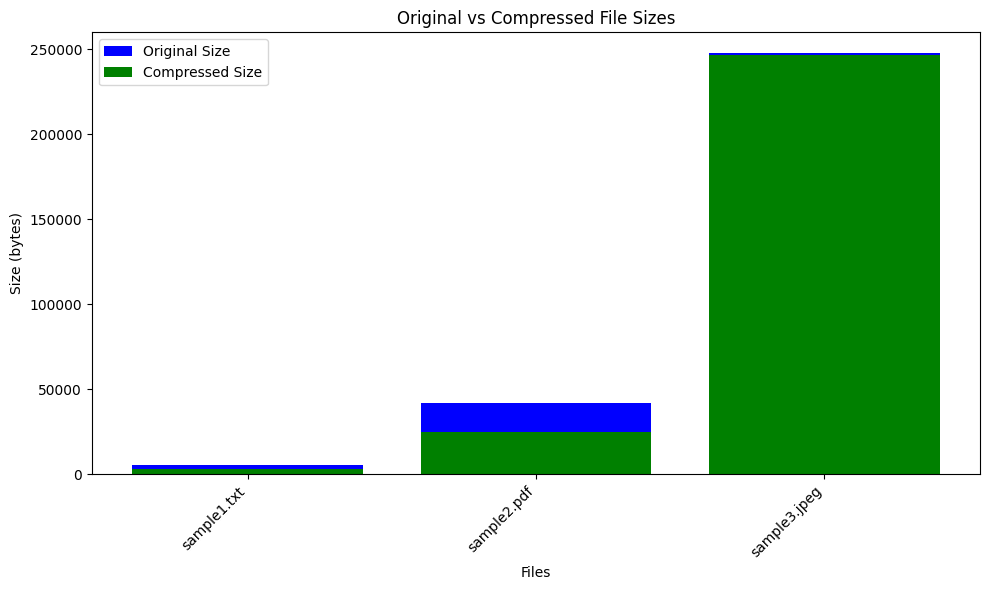

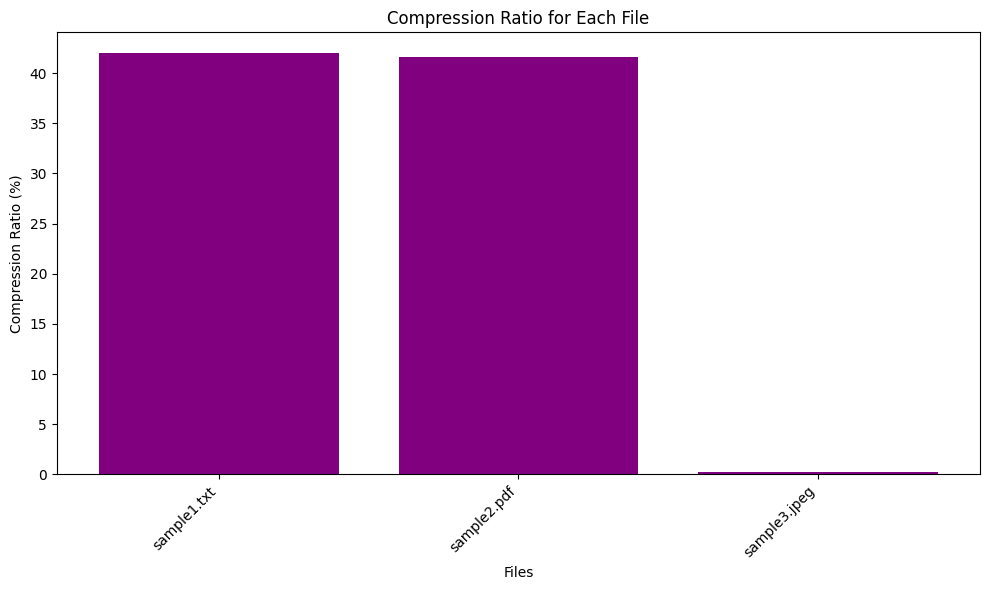

Starting decompression...
File 'sample1_compressed.bin' decompressed to 'sample1_compressed_decompressed.txt'
File 'sample2_compressed.bin' decompressed to 'sample2_compressed_decompressed.pdf'
File 'sample3_compressed.bin' decompressed to 'sample3_compressed_decompressed.jpeg'

Total Decompression Time: 0.16 seconds


In [1]:
import heapq
import os
import time
import matplotlib.pyplot as plt
from typing import List, Dict

class BinaryTree:
    def __init__(self, value, frequ):
        self.value = value
        self.frequ = frequ
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequ < other.frequ

    def __eq__(self, other):
        return self.frequ == other.frequ

class Huffmancode:
    def __init__(self, files: List[str], compression_level='Balanced'):
        self.files = files
        self.__heap = []
        self.__code = {}
        self.__reverse_code = {}
        self.compression_level = compression_level
        self.algorithm = 'huffman'

    def _frequency_from_bytes(self, byte_data):
        frequ_dict = {}
        for byte in byte_data:
            if byte not in frequ_dict:
                frequ_dict[byte] = 0
            frequ_dict[byte] += 1
        return frequ_dict

    def _build_heap(self, frequency_dict):
        for key in frequency_dict:
            frequency = frequency_dict[key]
            binary_tree_node = BinaryTree(key, frequency)
            heapq.heappush(self.__heap, binary_tree_node)

    def _build_binary_tree(self):
        while len(self.__heap) > 1:
            binary_tree_node_1 = heapq.heappop(self.__heap)
            binary_tree_node_2 = heapq.heappop(self.__heap)
            sum_of_freq = binary_tree_node_1.frequ + binary_tree_node_2.frequ
            newnode = BinaryTree(None, sum_of_freq)
            newnode.left = binary_tree_node_1
            newnode.right = binary_tree_node_2
            heapq.heappush(self.__heap, newnode)

    def _build_binary_code_helper(self, root, curr_bits):
        if root is None:
            return
        if root.value is not None:
            self.__code[root.value] = curr_bits
            self.__reverse_code[curr_bits] = root.value
            return
        self._build_binary_code_helper(root.left, curr_bits + '0')
        self._build_binary_code_helper(root.right, curr_bits + '1')

    def _build_binary_code(self):
        root = heapq.heappop(self.__heap)
        self._build_binary_code_helper(root, '')

    def _build_encoded_text(self, byte_data):
        encoded_text = ''
        for byte in byte_data:
            encoded_text += self.__code[byte]
        return encoded_text

    def _build_padded_text(self, encoded_text):
        padding_value = 8 - len(encoded_text) % 8
        for i in range(padding_value):
            encoded_text += '0'
        padded_info = "{0:08b}".format(padding_value)
        padded_text = padded_info + encoded_text
        return padded_text

    def _build_byte_array(self, padded_text):
        array = []
        for i in range(0, len(padded_text), 8):
            byte = padded_text[i:i + 8]
            array.append(int(byte, 2))
        return array

    def compression(self):
        print("Starting compression...")
        total_compressed_size = 0
        total_original_size = 0
        compression_start_time = time.time()
        compressed_file_paths = []  
        file_metrics = []  

        for file_path in self.files:
            filename, file_extension = os.path.splitext(file_path)
            output_path = filename + '_compressed.bin'
            with open(file_path, 'rb') as file, open(output_path, 'wb') as output:
                byte_data = file.read()
                original_size = len(byte_data)
                frequency_dict = self._frequency_from_bytes(byte_data)
                self._build_heap(frequency_dict)
                self._build_binary_tree()
                self._build_binary_code()
                encoded_text = self._build_encoded_text(byte_data)
                padded_text = self._build_padded_text(encoded_text)
                byte_array = self._build_byte_array(padded_text)
                final_bytes = bytes(byte_array)
                output.write(final_bytes)

                compressed_size = len(final_bytes)
                total_original_size += original_size
                total_compressed_size += compressed_size

                compressed_file_paths.append(output_path)  

                
                file_metrics.append({
                    'filename': file_path,
                    'original_size': original_size,
                    'compressed_size': compressed_size,
                    'compression_ratio': (original_size - compressed_size) / original_size * 100
                })

            print(f"File '{file_path}' compressed to '{output_path}'")
            print(f"Original Size: {original_size} bytes, Compressed Size: {compressed_size} bytes")
            print(f"Compression Ratio: {(original_size - compressed_size) / original_size * 100:.2f}%")

        compression_time = time.time() - compression_start_time
        print(f"\nTotal Compression Time: {compression_time:.2f} seconds")
        print(f"Overall Compression Ratio: {(total_original_size - total_compressed_size) / total_original_size * 100:.2f}%")

        #results
        self._visualize_results(file_metrics)
        return compressed_file_paths  

    def _visualize_results(self, file_metrics):
        filenames = [metric['filename'] for metric in file_metrics]
        original_sizes = [metric['original_size'] for metric in file_metrics]
        compressed_sizes = [metric['compressed_size'] for metric in file_metrics]
        compression_ratios = [metric['compression_ratio'] for metric in file_metrics]

        
        plt.figure(figsize=(10, 6))
        plt.bar(filenames, original_sizes, color='blue', label='Original Size')
        plt.bar(filenames, compressed_sizes, color='green', label='Compressed Size')
        plt.xlabel('Files')
        plt.ylabel('Size (bytes)')
        plt.title('Original vs Compressed File Sizes')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        
        plt.figure(figsize=(10, 6))
        plt.bar(filenames, compression_ratios, color='purple')
        plt.xlabel('Files')
        plt.ylabel('Compression Ratio (%)')
        plt.title('Compression Ratio for Each File')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def decompress(self, compressed_file_paths: List[str]):
        print("Starting decompression...")
        decompression_start_time = time.time()

        for input_path in compressed_file_paths:
            filename, file_extension = os.path.splitext(input_path)
            original_file_extension = os.path.splitext(self.files[compressed_file_paths.index(input_path)])[1]
            output_path = filename + '_decompressed' + original_file_extension
            with open(input_path, 'rb') as file, open(output_path, 'wb') as output:
                bit_string = ''.join(f'{byte:08b}' for byte in file.read())
                text_after_removing_padding = self._remove_padding(bit_string)
                actual_data = self._decode_text(text_after_removing_padding)
                output.write(actual_data)

            print(f"File '{input_path}' decompressed to '{output_path}'")

        decompression_time = time.time() - decompression_start_time
        print(f"\nTotal Decompression Time: {decompression_time:.2f} seconds")

    def _remove_padding(self, padded_text):
        padding_info = padded_text[:8]
        padding_value = int(padding_info, 2)
        padded_text = padded_text[8:]  
        return padded_text[:-padding_value]  

    def _decode_text(self, text):
        current_bits = ''
        decoded_bytes = bytearray()
        for bit in text:
            current_bits += bit
            if current_bits in self.__reverse_code:
                decoded_bytes.append(self.__reverse_code[current_bits])
                current_bits = ''
        return decoded_bytes


files_to_compress = ['sample1.txt', 'sample2.pdf', 'sample3.jpeg'] 
compression_level = 'Balanced'  # Options: 'Fast', 'Balanced', 'Max'
huffman = Huffmancode(files=files_to_compress, compression_level=compression_level)

compressed_file_paths = huffman.compression()  

# Decompressing
huffman.decompress(compressed_file_paths)


Starting compression...
File '/Users/akshitha/Downloads/competative_code project/sample2.pdf' compressed to '/Users/akshitha/Downloads/competative_code project/sample2_compressed.bin'
Original Size: 42272 bytes, Compressed Size: 24676 bytes
Compression Ratio: 41.63%

Total Compression Time: 0.01 seconds
Overall Compression Ratio: 41.63%


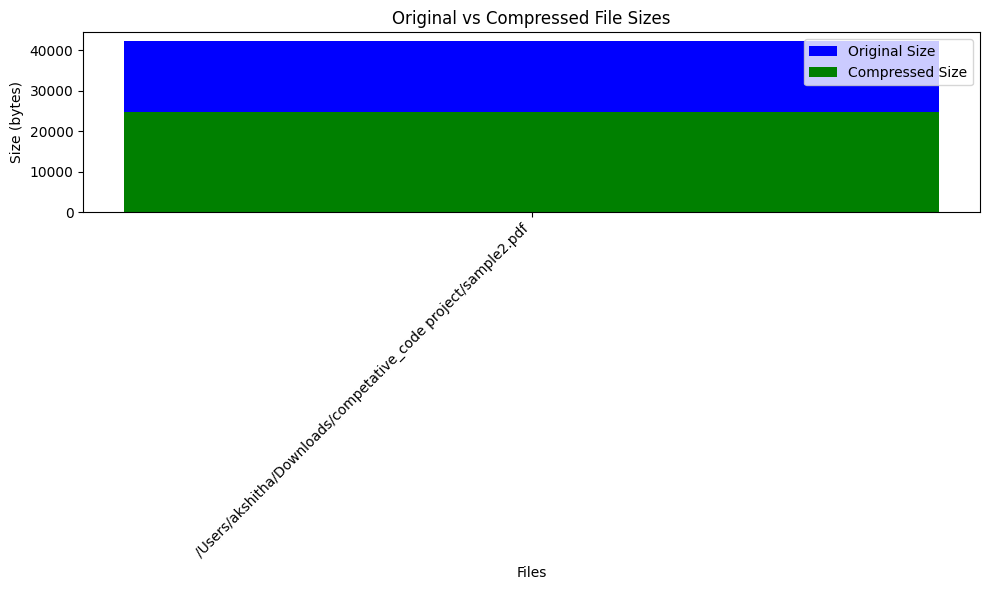

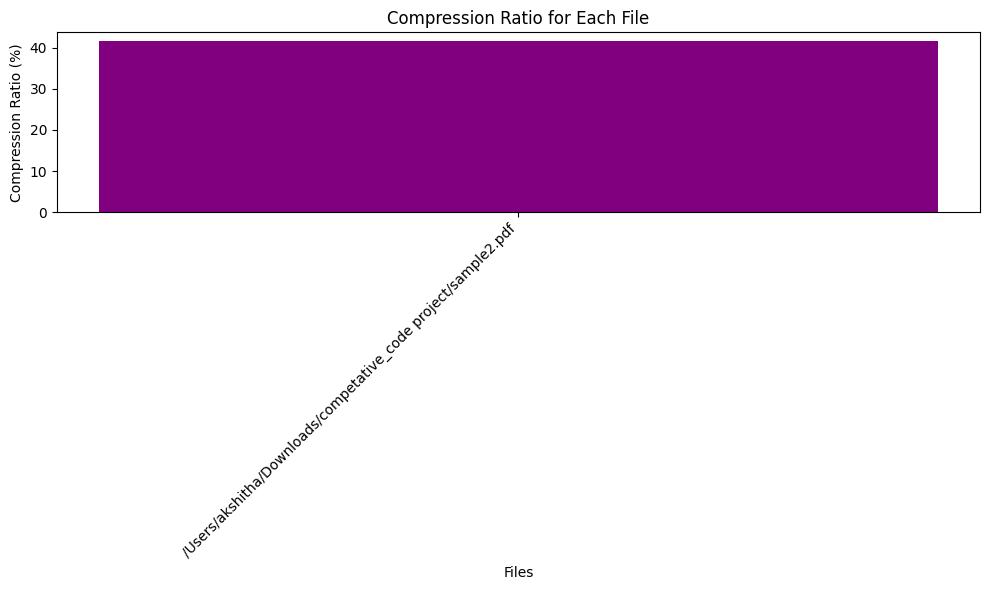

Starting decompression...
File '/Users/akshitha/Downloads/competative_code project/sample2_compressed.bin' decompressed to '/Users/akshitha/Downloads/competative_code project/sample2_compressed_decompressed.pdf'

Total Decompression Time: 0.01 seconds


In [4]:
import heapq
import os
import time
import matplotlib.pyplot as plt
from typing import List
from tkinter import Tk, filedialog

class BinaryTree:
    def __init__(self, value, frequ):
        self.value = value
        self.frequ = frequ
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequ < other.frequ

    def __eq__(self, other):
        return self.frequ == other.frequ

class Huffmancode:
    def __init__(self, files: List[str], compression_level='Balanced'):
        self.files = files
        self.__heap = []
        self.__code = {}
        self.__reverse_code = {}
        self.compression_level = compression_level
        self.algorithm = 'huffman'

    def _frequency_from_bytes(self, byte_data):
        frequ_dict = {}
        for byte in byte_data:
            if byte not in frequ_dict:
                frequ_dict[byte] = 0
            frequ_dict[byte] += 1
        return frequ_dict

    def _build_heap(self, frequency_dict):
        for key in frequency_dict:
            frequency = frequency_dict[key]
            binary_tree_node = BinaryTree(key, frequency)
            heapq.heappush(self.__heap, binary_tree_node)

    def _build_binary_tree(self):
        while len(self.__heap) > 1:
            binary_tree_node_1 = heapq.heappop(self.__heap)
            binary_tree_node_2 = heapq.heappop(self.__heap)
            sum_of_freq = binary_tree_node_1.frequ + binary_tree_node_2.frequ
            newnode = BinaryTree(None, sum_of_freq)
            newnode.left = binary_tree_node_1
            newnode.right = binary_tree_node_2
            heapq.heappush(self.__heap, newnode)

    def _build_binary_code_helper(self, root, curr_bits):
        if root is None:
            return
        if root.value is not None:
            self.__code[root.value] = curr_bits
            self.__reverse_code[curr_bits] = root.value
            return
        self._build_binary_code_helper(root.left, curr_bits + '0')
        self._build_binary_code_helper(root.right, curr_bits + '1')

    def _build_binary_code(self):
        root = heapq.heappop(self.__heap)
        self._build_binary_code_helper(root, '')

    def _build_encoded_text(self, byte_data):
        encoded_text = ''
        for byte in byte_data:
            encoded_text += self.__code[byte]
        return encoded_text

    def _build_padded_text(self, encoded_text):
        padding_value = 8 - len(encoded_text) % 8
        for i in range(padding_value):
            encoded_text += '0'
        padded_info = "{0:08b}".format(padding_value)
        padded_text = padded_info + encoded_text
        return padded_text

    def _build_byte_array(self, padded_text):
        array = []
        for i in range(0, len(padded_text), 8):
            byte = padded_text[i:i + 8]
            array.append(int(byte, 2))
        return array

    def compression(self):
        print("Starting compression...")
        total_compressed_size = 0
        total_original_size = 0
        compression_start_time = time.time()
        compressed_file_paths = []  
        file_metrics = []  

        for file_path in self.files:
            filename, file_extension = os.path.splitext(file_path)
            output_path = filename + '_compressed.bin'
            with open(file_path, 'rb') as file, open(output_path, 'wb') as output:
                byte_data = file.read()
                original_size = len(byte_data)
                frequency_dict = self._frequency_from_bytes(byte_data)
                self._build_heap(frequency_dict)
                self._build_binary_tree()
                self._build_binary_code()
                encoded_text = self._build_encoded_text(byte_data)
                padded_text = self._build_padded_text(encoded_text)
                byte_array = self._build_byte_array(padded_text)
                final_bytes = bytes(byte_array)
                output.write(final_bytes)

                compressed_size = len(final_bytes)
                total_original_size += original_size
                total_compressed_size += compressed_size

                compressed_file_paths.append(output_path)  

                
                file_metrics.append({
                    'filename': file_path,
                    'original_size': original_size,
                    'compressed_size': compressed_size,
                    'compression_ratio': (original_size - compressed_size) / original_size * 100
                })

            print(f"File '{file_path}' compressed to '{output_path}'")
            print(f"Original Size: {original_size} bytes, Compressed Size: {compressed_size} bytes")
            print(f"Compression Ratio: {(original_size - compressed_size) / original_size * 100:.2f}%")

        compression_time = time.time() - compression_start_time
        print(f"\nTotal Compression Time: {compression_time:.2f} seconds")
        print(f"Overall Compression Ratio: {(total_original_size - total_compressed_size) / total_original_size * 100:.2f}%")

        #results
        self._visualize_results(file_metrics)
        return compressed_file_paths  

    def _visualize_results(self, file_metrics):
        filenames = [metric['filename'] for metric in file_metrics]
        original_sizes = [metric['original_size'] for metric in file_metrics]
        compressed_sizes = [metric['compressed_size'] for metric in file_metrics]
        compression_ratios = [metric['compression_ratio'] for metric in file_metrics]

        
        plt.figure(figsize=(10, 6))
        plt.bar(filenames, original_sizes, color='blue', label='Original Size')
        plt.bar(filenames, compressed_sizes, color='green', label='Compressed Size')
        plt.xlabel('Files')
        plt.ylabel('Size (bytes)')
        plt.title('Original vs Compressed File Sizes')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        
        plt.figure(figsize=(10, 6))
        plt.bar(filenames, compression_ratios, color='purple')
        plt.xlabel('Files')
        plt.ylabel('Compression Ratio (%)')
        plt.title('Compression Ratio for Each File')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def decompress(self, compressed_file_paths: List[str]):
        print("Starting decompression...")
        decompression_start_time = time.time()

        for input_path in compressed_file_paths:
            filename, file_extension = os.path.splitext(input_path)
            original_file_extension = os.path.splitext(self.files[compressed_file_paths.index(input_path)])[1]
            output_path = filename + '_decompressed' + original_file_extension
            with open(input_path, 'rb') as file, open(output_path, 'wb') as output:
                bit_string = ''.join(f'{byte:08b}' for byte in file.read())
                text_after_removing_padding = self._remove_padding(bit_string)
                actual_data = self._decode_text(text_after_removing_padding)
                output.write(actual_data)

            print(f"File '{input_path}' decompressed to '{output_path}'")

        decompression_time = time.time() - decompression_start_time
        print(f"\nTotal Decompression Time: {decompression_time:.2f} seconds")

    def _remove_padding(self, padded_text):
        padding_info = padded_text[:8]
        padding_value = int(padding_info, 2)
        padded_text = padded_text[8:]  
        return padded_text[:-padding_value]  

    def _decode_text(self, text):
        current_bits = ''
        decoded_bytes = bytearray()
        for bit in text:
            current_bits += bit
            if current_bits in self.__reverse_code:
                decoded_bytes.append(self.__reverse_code[current_bits])
                current_bits = ''
        return decoded_bytes


def select_files():
    root = Tk()
    root.withdraw()  
    files = filedialog.askopenfilenames(title="Select Files for Compression")
    root.destroy()
    return list(files)

# User selects files
files_to_compress = select_files()
compression_level = 'Balanced'  # Options: 'Fast', 'Balanced', 'Max'
huffman = Huffmancode(files=files_to_compress, compression_level=compression_level)

# Compress the selected files
compressed_file_paths = huffman.compression()  

# Decompress the files
huffman.decompress(compressed_file_paths)
